## Test fonction run exp

### 1. Imports

In [2]:
import torch
import math
import stat_reliability_measure.config as config_
from importlib import reload
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'stat_reliability_measure.config'

In [2]:
config_.t_u

<module 'stat_reliability_measure.dev.torch_utils' from '/nfs/nas4/bbonnet/bbonnet/ktit/stat_reliability_measure/dev/torch_utils.py'>

In [3]:
import stat_reliability_measure.dev.torch_utils as t_u

from stat_reliability_measure.dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_exp as run_exp
from stat_reliability_measure.config import Exp2Config
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.smc.smc_config as smc_config

import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import stat_reliability_measure.dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
import stat_reliability_measure.dev.hmls.hmls_pyt as hmls_pyt
import stat_reliability_measure.dev.hmls.hmls_config as hmls_config

import stat_reliability_measure.dev.torch_arch as t_a
from stat_reliability_measure.dev.utils import range_vars,simple_vars
import pandas as pd
import numpy as np
import os 


### 2. Model & Data load

In [6]:
reload(config_)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
model = t_a.dnn2()
model.load_state_dict(torch.load('../../models/mnist/model_dnn2_release.pt'))
model.to(device)
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../../models/mnist/model_dnn2_release.pt'

In [6]:
config = Exp2Config(method_name="amls_webb", model=model)

In [7]:
config.update()
os.rmdir(config.exp_log_path)

In [8]:
X,y = config.X[:1], config.y[:1]
x_0 = X[0]

In [9]:
config.sample_accuracy

0.9921875

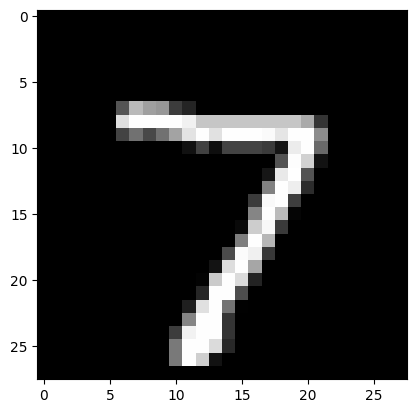

In [10]:
t_u.plot_tensor(config.X[0].view(28,28))

## 3. Experiments with MALA-SMC, ours implementation and Webb's implementation of AMLS algorithm

In [19]:
epsilon_range=[0.18]
dataset='mnist'
n_ref = 200 
method_ref='MALA_SMC'
N_ref = 10000
T_ref = 100
ess_ref = 0.8
alpha_ref = 0.2
n_rep_ref = 100

In [20]:
X.requires_grad = True

In [21]:
p_ref, dict_out=run_exp.run_est(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=n_ref, verbose=0, track_accept=False,ess_alpha_range=[
                                                                                 ess_ref],
                        alpha=alpha_ref, L_range=[1], adapt_func='simp_ess',
                         N_range=[N_ref],T_range=[T_ref],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_ref = dict_out['results_df']
print(f"p_fail_mala={p_ref}")

with parameters in {'N_range': [10000], 'T_range': [100], 'ess_alpha_range': [0.8], 'alpha_range': [0.2], 'L_range': [1]}
aggregate results csv file not found 
 it will be build at /home/karim-tito/stat_reliability_measure/logs/exp_2_mnist/aggr_res.csv
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 10000: T: 100: ess_alpha: 0.8: alpha: 0.2: L: 1


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [12:25<00:00,  3.73s/it]


mean est:1.9609817691446097e-07, std est:7.143952766709725e-09
mean calls:2363647.825
std. re.:185776.79329089395
std. rel. adj.:439110913397.4961
p_fail_mala=1.9609817691446097e-07


In [23]:
ref_exp = utils.get_sel_df(df=agg_res_df, triplets=[('method_name',method_ref,'='),('n_rep',n_ref,'='),
                                                    ('epsilon',epsilon_range[0],'='),
        ('N',N_ref,'='),('T',T_ref,'='),('alpha',alpha_ref,'='), ])
p_ref,std_ref =ref_exp['mean_est'].values[0], ref_exp['std_est'].values[0]
agg_res_df = pd.read_csv('../../logs/exp_2_mnist/aggr_res.csv')
p_ref,std_ref

(1.9609817691446097e-07, 7.143952766709725e-09)

In [53]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(run_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(mc_config)
reload(mc_pyt)
reload(hmls_config)
reload(hmls_pyt)

<module 'stat_reliability_measure.dev.hmls.hmls_pyt' from '/home/karim-tito/stat_reliability_measure/dev/hmls/hmls_pyt.py'>

In [67]:
p_fail_hmls, dict_out=run_exp.run_stat_rel_exp(model=model,method='hmls',X=X,y=y,dataset_name='mnist',
                        n_rep=200, verbose=0, track_accept=False,ratio_range=[0.5],track_levels=True,
                        alpha=0.25, L_range=[1], only_duplicated=True,p_ref=p_ref,
                      track_X=False, track_advs=True,np_seed=1,torch_seed=0,
                         N_range=[5000],T_range=[2],epsilon_range=epsilon_range,repeat_exp=True,
 )


exp_config,method_config_hmls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_hmls = dict_out['results_df']

X_hmls_adv = dict_out['advs_list'][0]
img_hmls_adv = exp_config.gaussian_to_image(torch.Tensor(X_hmls_adv).to(exp_config.device))
quant_img_hmls_adv = t_u.quantize_img(img_hmls_adv)/255.
y_hmls_adv = model(img_hmls_adv).argmax(dim=1)
normal_layer = t_u.NormalCDFLayer(device = exp_config.device,offset = x_0, epsilon=epsilon_range[0])
def gaussian_to_image(gaussian_sample,normal_layer=normal_layer,image_shape=(28,28)):
    image = normal_layer(gaussian_sample.view(-1,*image_shape))
    return image
print(f"p_fail_hmls={p_fail_hmls}")

with parameters in {'N_range': [5000], 'T_range': [2], 'ratio_range': [0.5], 'alpha_range': [0.25], 'L_range': [1]}
Starting HMLS simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 5000: T: 2: ratio: 0.5: alpha: 0.25: L: 1


100%|██████████| 200/200 [04:28<00:00,  1.34s/it]


mean est:1.99066162109375e-07, std est:2.2736623339982534e-08
mean calls:563750.0
std. re.:573761.0730467502
std. rel. adj.:323457804930.1054
mean rel. error:0.09227410695836116
std rel. error:0.07437759129466982
stat performance (per 1k calls):41.93036709237011
p_fail_hmls=1.99066162109375e-07


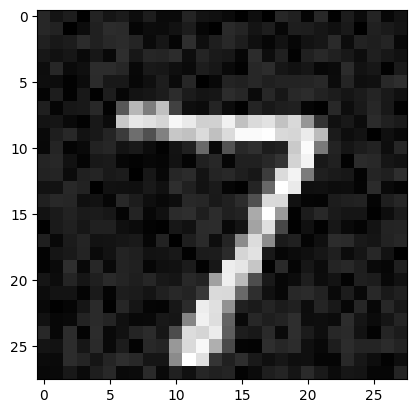

In [64]:
plt.imshow(quant_img_hmls_adv[0].cpu().detach().view(28,28).numpy(),cmap='gray')

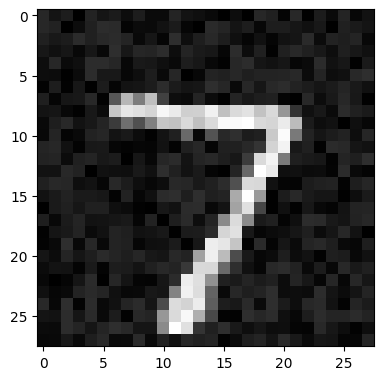

In [65]:
t_u.plot_k_tensor(img_hmls_adv[0],figsize=(20,20))

In [66]:
p_fail_mls,dict_out=run_exp.run_stat_rel_exp(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=100, update_aggr_res=False, 
                         N_range=[5000],T_range=[10],ratio_range=[0.5,],repeat_exp=False,
                         track_levels=True,track_X=True,
                        verbose=1,np_seed=0, torch_seed=0,p_ref = p_ref)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
X_amls=dict_out['X_list'][0]
X_amls_adv = X_amls[exp_config.V(X_amls)==0.]
img_amls_adv = exp_config.gaussian_to_image(X_amls_adv)
quant_img_amls_adv = t_u.quantize_img(img_amls_adv)/255.
y_amls_adv = model(img_amls_adv).argmax(dim=1)
y_quant_amls_adv = model(quant_img_amls_adv).argmax(dim=1)
print(f"p_fail_mls: {p_fail_mls}")

Running reliability experiments on architecture custom trained on mnist.
Testing uniform noise pertubation with epsilon in [0.18]
with parameters in {'N_range': [5000], 'T_range': [10], 'ratio_range': [0.5], 's_range': [1.0]}
Starting MLS_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 5000: T: 10: ratio: 0.5: s: 1.0


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


mean est:1.9563722610473633e-07, std est:1.802299091870413e-08
mean calls:554250.0
std. re.:470894.77438090806
std. rel. adj.:260993428700.6183
mean rel. error:0.07229880003433924
std rel. error:0.05772106105673312
stat performance (per 1k calls):31.991898090694335
p_fail_mls: 1.9563722610473633e-07


In [218]:
(t_u.compute_V_pyt(model=model,
                  input_=img_amls_adv,
                  target_class=7,)!=0).float().mean()

tensor(0., device='cuda:0')

In [219]:
(t_u.compute_V_pyt(model=model,
                  input_=quant_img_amls_adv,
                  target_class=7,)!=0).float().mean()

tensor(0.0161, device='cuda:0')

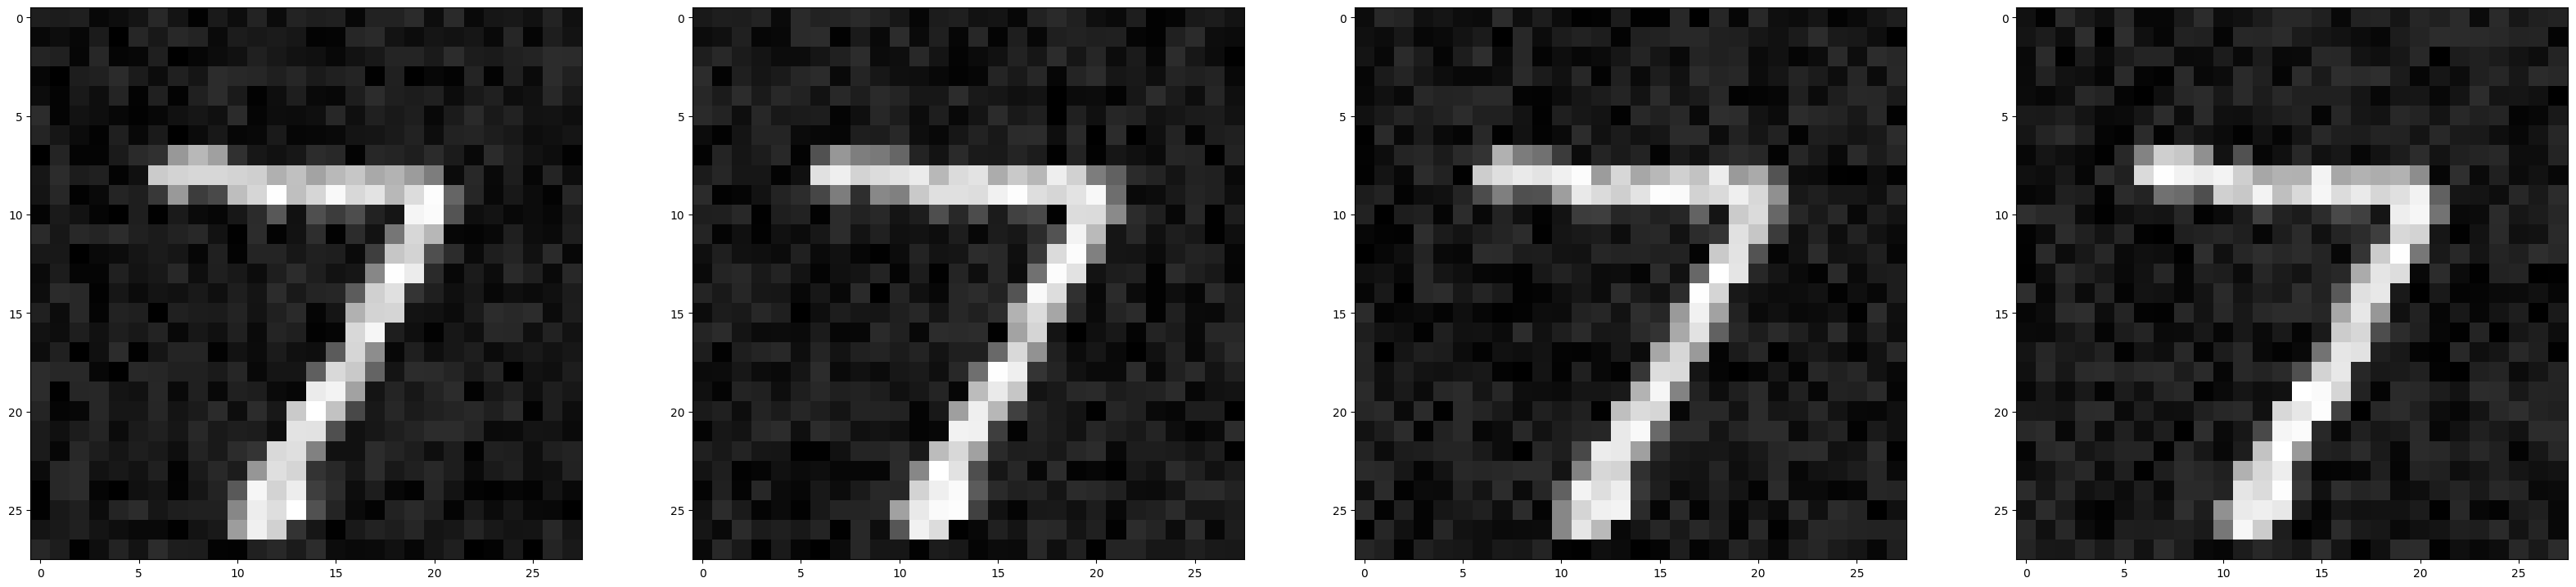

In [220]:
t_u.plot_k_tensor(exp_config.gaussian_to_image(X_amls_adv[:4]))

In [50]:
np.loadtxt(results_df_hmls['levels_path'].values[0])

array([-0.76788175, -0.35148048, -0.21802711, -0.14902183, -0.1041557 ,
       -0.06463497,  0.        ])

In [51]:
np.loadtxt(results_df_mls['levels_path'].values[0],)

array([-1.30634975, -0.92414951, -0.6576128 , -0.44019127, -0.2548995 ,
       -0.10884476,  0.038661  ])

In [225]:
p_fail_webb,dict_out=run_exp.run_stat_rel_exp(model=model,method='amls_webb',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=1, update_aggr_res=False, p_ref=p_ref,
                         N_range=[2000],T_range=[1000,],ratio_range=[0.1,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0 ,)
exp_config,method_config_webb, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_webb=dict_out['results_df']
print(f"p_fail_webb={p_fail_webb}")

Running reliability experiments on architecture custom trained on mnist.
Testing uniform noise pertubation with epsilon in [0.18]
with parameters in {'N_range': [2000], 'T_range': [1000], 'ratio_range': [0.1]}
Starting MLS_Webb simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 2000: T: 1000: ratio: 0.1


100%|██████████| 1/1 [00:40<00:00, 40.25s/it]


mean est:1.875000947211994e-07, std est:0.0
mean calls:14014000.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.03823284873753003
std rel. error:0.0
stat performance (per 1k calls):0.0
p_fail_webb=1.875000947211994e-07


In [72]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[
                                                                                 0.75],
                        alpha=0.25, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[500],T_range=[5],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

with parameters in {'N_range': [500], 'T_range': [5], 'ess_alpha_range': [0.75], 'alpha_range': [0.25], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 5: ess_alpha: 0.75: alpha: 0.25: L: 1


100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


mean est:1.9215423257890052e-07, std est:3.9971514994941794e-08
mean calls:83603.5
std. re.:1082556.8164076288
std. rel. adj.:90505538800.5352
mean rel. error:0.16467556709686676
std rel. error:0.12298691507490064
stat performance (per 1k calls):10.282136554464456
p_fail_mala=1.9215423257890052e-07


In [20]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=10, verbose=0, track_accept=False,ess_alpha_range=[0.875],
                        alpha=0.2, L_range=[1], adapt_func='ess',
                         N_range=[500],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

with parameters in {'N_range': [500], 'T_range': [20], 'ess_alpha_range': [0.875], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 20: ess_alpha: 0.875: alpha: 0.2: L: 1


100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


mean est:1.9169501683791168e-07, std est:2.7047004532370744e-08
mean calls:139566.0
std. re.:736033.4077725433
std. rel. adj.:102725238589.18277
p_fail_mala=1.9169501683791168e-07


In [240]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='smc_multi',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[0.875],
                        alpha=0.2, L_range=[1], adapt_func='ess',
                         N_range=[500],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

with parameters in {'N_range': [500], 'T_range': [20], 'ess_alpha_range': [0.875], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 500: T: 20: ess_alpha: 0.875: alpha: 0.2: L: 1


100%|██████████| 100/100 [03:55<00:00,  2.36s/it]


mean est:1.9335658777208664e-07, std est:3.233486137111052e-08
mean calls:138139.65
std. re.:864874.428600197
std. rel. adj.:119473450860.78119
p_fail_mala=1.9335658777208664e-07


In [234]:
model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [232]:
1125858/5e7

0.02251716

In [233]:
p_fail_form,dict_out_form = run_exp.run_stat_rel_exp(model=model,method='form',X=X,y=y,dataset_name='mnist',
                    search_method='carlini',epsilon_range = epsilon_range,
                    steps_range=[1000,],num_iter_range=[10],stepsize_range=[1e-2],
                    repeat_exp=True, random_init=False, 
                    sigma_init=0.000001,
                        
                        
                        n_rep=1, verbose=0,p_ref=p_ref)

with parameters in {'steps_range': [1000], 'num_iter_range': [10], 'stepsize_range': [0.01]}
Starting FORM simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,steps: 1000: num_iter: 10: stepsize: 0.01


100%|██████████| 1/1 [00:20<00:00, 20.67s/it]


mean est:2.019410905655691e-12, std est:0.0
mean calls:10000.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.9999896415888384
std rel. error:0.0
stat performance (per 1k calls):0.0


In [74]:
p_fail_mc, dict_out_mc = run_exp.run_stat_rel_exp(model=model, method = 'CrudeMC',
            X=X, y=y, dataset_name='mnist',epsilon_range=epsilon_range,
            repeat_exp=True,n_rep=5, 
            N_range=[int(1e8)],batch_size_range=[int(4e5)],track_advs=False) 

with parameters in {'N_range': [100000000], 'batch_size_range': [400000]}
Starting CrudeMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,N: 100000000: batch_size: 400000


100%|██████████| 5/5 [02:43<00:00, 32.75s/it]


mean est:2.300000261357127e-07, std est:5.403701663908578e-08
mean calls:100000000.0
std. re.:1021493.4661295576
std. rel. adj.:102149346612955.77


In [75]:
exp_config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

## 4. Analysis of Experiments

In [76]:
eps=0.18

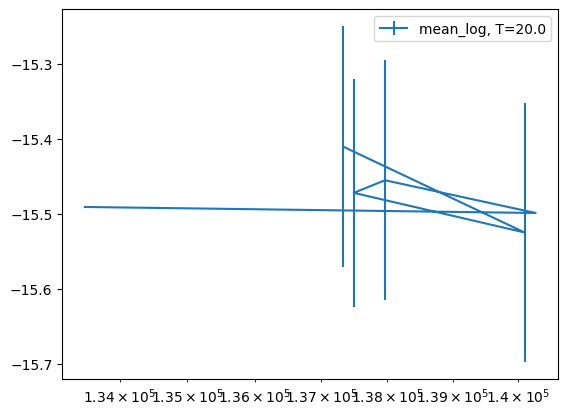

In [82]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mala_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MALA_SMC','='),])
df = utils.get_sel_df(mala_df,triplets=[('epsilon',eps,'='),('ess_alpha',0.875,'='),('alpha',0.25,'=')])
for T in df['T'].unique():
    df = utils.get_sel_df(df,triplets=[('T',T,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

